In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import numpy as np
import matplotlib
%matplotlib inline

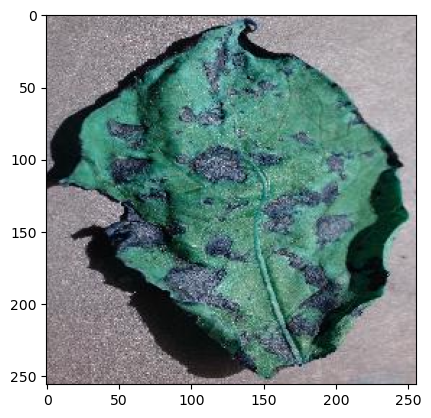

In [33]:
img_url = './training_dataset/early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG'

img = cv2.imread(img_url)

plt.imshow(img)
plt.show()

In [35]:
img.shape

(256, 256, 3)

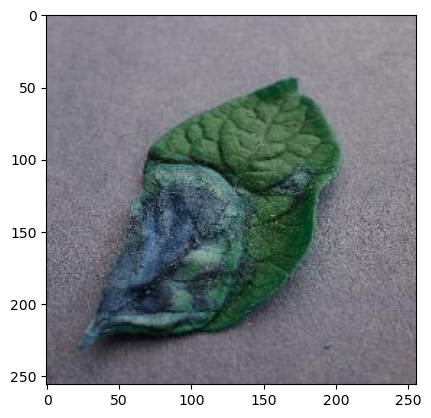

In [22]:
img_url = './training_dataset/late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG'
img = cv2.imread(img_url)

plt.imshow(img)
plt.show()

Convert the images to black and white, then stack the images vertically and store into an array

In [29]:
# dictionary of directories

import os
dirs = os.listdir('./training_dataset')
dir_dict = {}

count = 0
for dire in dirs:
    dir_dict[dire] = count
    count += 1

In [67]:
import os
img_dirs = []
dir_names = {}
training_url = './training_dataset/'

count = 0
for entry in os.scandir(training_url):
    if entry.is_dir():
        img_dirs.append(entry.path)
        dir_names[entry.name] = count
        count += 1
        
print(img_dirs)
print(dir_names)

['./training_dataset/early_blight', './training_dataset/healthy', './training_dataset/late_blight']
{'early_blight': 0, 'healthy': 1, 'late_blight': 2}


In [31]:
dir_dict

{'early_blight': 0, 'healthy': 1, 'late_blight': 2}

In [49]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt

def w2d(img, mode='haar', level=1):
    imArray = img
    # convert to grayscale
    imArray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # convert to float
    imArray = np.float64(imArray)
    # normalize: to convert values from 0 to 1
    imArray /= 255
    # compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level)
    #process coeffs: approximations and details
    coeffs_H=list(coeffs)  
    # set approximate coeffs to zero - removes coarse noise, emphasizes edges
    coeffs_H[0] *= 0;
    # reconstruction: using cleaned signal
    imArray_H = pywt.waverec2(coeffs_H, mode)
    # denormalize: to get back rgb values
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [81]:
X = []
y = []

for im_dir in img_dirs:
    dir_name = im_dir.split('/')[-1]
    for file in os.scandir(im_dir):
        img = cv2.imread(file.path)
        
        if img is None:
            print(f"Failed to load image: {file}")
            continue 
        
        img_har = w2d(img, 'db1', 5)

        combined_img = np.vstack(( img.reshape(256*256*3, 1), img_har.reshape(256*256, 1) ))
        X.append(combined_img)
        y.append(dir_dict[dir_name])

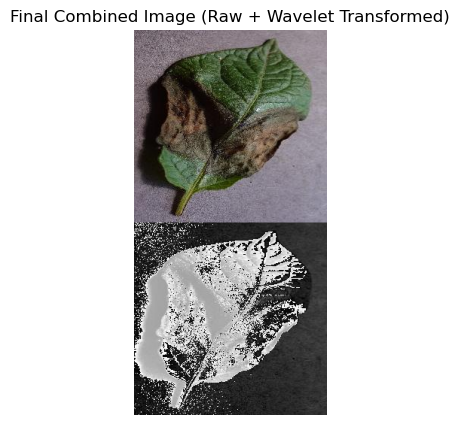

In [99]:
import matplotlib.pyplot as plt

# Assuming combined_img is flattened array
raw_img_flattened = combined_img[:256*256*3]  # Raw image flattened part
har_img_flattened = combined_img[256*256*3:]  # Wavelet image flattened part

# Reshape the raw and wavelet parts back to their original shapes
scaled_raw_img = raw_img_flattened.reshape(256, 256, 3)
scaled_img_har = har_img_flattened.reshape(256, 256)

# Convert the wavelet image (grayscale) to 3 channels for display
scaled_img_har_rgb = cv2.cvtColor(scaled_img_har, cv2.COLOR_GRAY2BGR)

# Stack the two images vertically (to match the combined image)
combined_canvas = np.vstack((scaled_raw_img, scaled_img_har_rgb))

# Visualize the final combined image
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(combined_canvas, cv2.COLOR_BGR2RGB))
plt.title("Final Combined Image (Raw + Wavelet Transformed)")
plt.axis("off")
plt.show()

In [95]:
X[0].shape

(262144, 1)

In [97]:
y[0]

0

In [101]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [107]:
# convert the combined image to an np array of floats and a 1d array for each img, to feed the model
# take the whole X and make a 2d array, of len 4096 for each img

X = np.array(X).reshape(len(X), 256*256*3 + 256*256).astype(float)
y = np.array(y)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = Pipeline([('Scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('svc', SVC(C=10))])

In [110]:
pipe.score(X_test, y_test)

0.9443155452436195

In [111]:
# using GridSearchCV we got to know, svm with linear kernel and C=1 is best

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='linear', C=1))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='linear'))])

In [112]:
pipe.score(X_test, y_test)

0.9396751740139211

In [117]:
!pip install joblib
import joblib

joblib.dump(pipe, 'model.pkl')

['model.pkl']

In [121]:
import json

with open('class_dict.json', 'w') as f:
    json.dump(dir_names, f, indent=4)

In [ ]:
import pickle

